In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import H0, bin_file_comoving#, bin_file

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


# Set parameters


In [2]:
band   = "MW1"
zrange = (0.4,0.5)

rp_use_range = (0.1, None)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

boxsize = get_boxsize(sim_tag)

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

lf_name  = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()

abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)
#=========== END HOUSEKEEPING ===========#

t = Table(np.load(f"{BASEDIR}/mags_{cat_tag}_noLRG.npy"))

abs_mag_bin_cens   = [np.mean(abs_mag_bins_clust[i:i+2]) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_means  = [np.round(  np.mean( t[band][ (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])] ),3) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_meds   = [np.round(np.median( t[band][ (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])] ),3) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_counts = np.array([      len( t[band][ (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])] )    for i in range(len(abs_mag_bins_clust)-1)])

print(band)
print(zrange)

abs_mag_bin_count_weights = abs_mag_bin_counts/np.sum(abs_mag_bin_counts)

# print(abs_mag_bin_cens)
# print(abs_mag_bin_means)
# print(abs_mag_bin_meds)
# print(abs_mag_bin_counts)
# print(abs_mag_bin_count_weights)

params = dict(band=band,
              zrange=zrange, zmin=zmin, zmax=zmax,
              rp_use_range=rp_use_range,
              #brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch,
              zmag_lim=zmag_lim,
              sim_tag=sim_tag,
              sham_tag=sham_tag,
              d=d,
              pimax=pimax,
              h=h,
              z_snaps=z_snaps,
              snap_nums=snap_nums,
              a_snaps=a_snaps,
              snaps=snaps,
              hist_idx=hist_idx,
              vol_sim=vol_sim,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              cat_tag=cat_tag,
              abs_mag_lim=abs_mag_lim,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              zmag_tag=zmag_tag,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              n_mag_bins_clust=n_mag_bins_clust,
              abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              lum_func_full=lum_func_full,
#               pz_mask=pz_mask,
#               abs_mag_bin_cens=abs_mag_bin_cens,
#               abs_mag_bin_means=abs_mag_bin_means,
#               abs_mag_bin_counts=abs_mag_bin_counts,
#               abs_mag_bin_count_weights=abs_mag_bin_count_weights,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")



h = 0.6777


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


MW1
(0.4, 0.5)


# Linear fits to magnitude-dependent SHAM and LOS scatter parameters

### Compute and save $\chi^2(\omega_{\rm p})$ in magnitude bins (for $\sigma_{\rm SHAM}\times\sigma_{\rm LOS}$ grid)

In [ ]:
#grid = "coarse"
grid = "fine"

if grid=="coarse": #-- COARSE BINNING
    sigma_sham_array = np.round(np.arange(0.1,1.51,0.1),2)
    sigma_los_array  = np.arange(50,151,10)
else: #-- FINER BINNNING
    sigma_sham_array = np.round(np.arange(0.5,0.66,0.01),2)
    sigma_los_array = np.arange(50,121,5)

cross = "GXG"
brightest_mag_bin_rp1Mpch = False

rp_bins, rp_mids = rp_bins_from_file(bin_file_comoving)

out = {}

for idx,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
    print(abs_mag_bin_tag)
    sigma_sham_col = []
    sigma_los_col  = []
    chisq_col      = []
    pct_diff_1h    = []
    pct_diff_2h    = []
    
    #-- DATA
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

    data   = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"].data
    wp_dat = h*data["wp"].data
    wp_err = h*np.sqrt(data["wp_err"].data)

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
    cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
    cov_inv = np.linalg.inv(cov)

    #-- rp bins to include in chisq
    rp_use_min, rp_use_max = rp_use_range
    if (brightest_mag_bin_rp1Mpch==True) and ("n30p0" in abs_mag_bin_tag):
        if (rp_use_max != None):
            rp_use_idx = np.where((rp_cen > 1.0) & (rp_cen < rp_use_max))[0]
        else:
            rp_use_idx = np.where(rp_cen > 1.0)[0]
    else:
        if (rp_use_min != None) & (rp_use_max != None):
            rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
        elif (rp_use_min != None) & (rp_use_max==None):
            rp_use_idx = np.where(rp_cen > rp_use_min)[0]
        elif (rp_use_min==None) & (rp_use_max != None):
            rp_use_idx = np.where(rp_cen < rp_use_max)[0]
        else:
            rp_use_idx = np.arange(len(rp_cen))
    N_rp = len(rp_use_idx)

    rp_use_tag = get_rp_use_tag(rp_use_range, brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch,
                                return_tag=True, return_label=False)

    #-- MODELS
    for sigma_sham in sigma_sham_array:
        sigma_sham_tag = f"sigma_sham_const{str(sigma_sham).replace('.','p')}"
        fpath = f"{BASEDIR}/clustering/mocks/{sim_tag}/{sham_tag}/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/{sigma_sham_tag}"
        if os.path.exists(fpath):
            wp_fname = f"{zsnap_tag}_{d}_{cross}_pimax{int(pimax)}.npy"

            wp_models = np.load(f"{fpath}/{wp_fname}").item()

            for sigma_los in sigma_los_array:
                sigma_los_key = f"sigma_los_{int(sigma_los)}"
                if sigma_los_key in wp_models.keys():
                    #print(sigma_sham, sigma_los)
                    wp_mod = Table(wp_models[f"sigma_los_{int(sigma_los)}"])["wp"].data
                    chisq  = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])

                    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
                    two_halo = (rp_cen > 1.0)
                    pct_diff = 1 - wp_mod/wp_dat
                    #print( f"{np.mean(pct_diff[one_halo]):.3f} {np.mean(pct_diff[two_halo]):.3f}" )

                    sigma_sham_col.append(sigma_sham)
                    sigma_los_col.append(sigma_los)
                    chisq_int = int(chisq) if (chisq>0) else chisq
                    chisq_col.append(chisq_int)
                    pct_diff_1h.append(np.round(pct_diff[one_halo],3))
                    pct_diff_2h.append(np.round(pct_diff[two_halo],3))
            
    out[abs_mag_bin_tag] = Table(data=(chisq_col,sigma_sham_col,sigma_los_col,pct_diff_1h,pct_diff_2h),
                                 names=("chisq","sigma_sham","sigma_los","pct_diff_1h","pct_diff_2h"))

save_path = f"{BASEDIR}/chisq/{rp_use_tag}"
if grid=="coarse":
    save_fname = f"{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}_coarse.npy"
else:
    save_fname = f"{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"

Path( save_path ).mkdir(parents=True, exist_ok=True)

print(f"Saving {save_path}/{save_fname}...")
np.save(f"{save_path}/{save_fname}", out, allow_pickle=True)
                        

In [3]:
def load_chisq_linear(rp_use_range=None, d="south", band=None, zmin=None, sim_tag=None, coarse=False,
                      brightest_mag_bin_rp1Mpch=False):
    assert(sim_tag != None)
    rp_use_tag = get_rp_use_tag(rp_use_range, brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch, return_tag=True)

    out = []

    abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=4)
    #print(abs_mag_bins_clust)
    
    z_snaps,_,_ = get_zsnap_data(sim_tag)
    zsim      = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    zsim = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    abs_mag_lim = get_abs_mag_lim(zmin, band)
    if band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(abs_mag_lim)
    elif band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(abs_mag_lim)

    #-- load linear fit mag bin chisq data
    #print(rp_use_tag)
    if coarse==True:
        fname = f"{BASEDIR}/chisq/{rp_use_tag}/{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}_coarse.npy"
    else:
        fname = f"{BASEDIR}/chisq/{rp_use_tag}/{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"
    #print(fname)
    chisq_linear = np.load(fname, allow_pickle=True).item()

    #-- parse mag bin keys
    mag_bin_tags = list(chisq_linear.keys())

    #-- define mag bin centers
    mag_bin_edges = [-float(j[1:].replace("p",".")) for j in np.array([i.split("-") for i in mag_bin_tags]).T[1]]
            
    return chisq_linear
        

## View coarse-grained parameter space grid

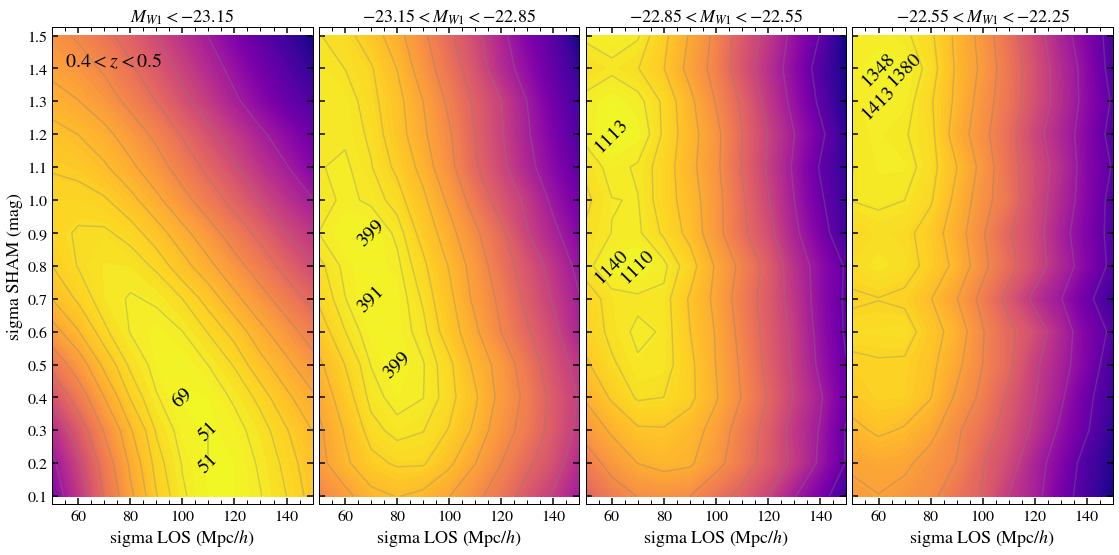

In [10]:
import matplotlib.colors as colors

brightest_mag_bin_rp1Mpch = False
save = False

chisq_linear = load_chisq_linear(rp_use_range=rp_use_range, sim_tag=sim_tag, band=band, zmin=zmin, coarse=True,
                                 brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)

fig1, axes = plt.subplots(1,4,figsize=(16,8), sharex=True, sharey=True)

mag_bin_tags = list(chisq_linear.keys())
    
y_sham = []
y_los  = []
chisq_val = []

for mag_bin_idx,ax in zip(np.arange(4),axes):
    tab = chisq_linear[mag_bin_tags[mag_bin_idx]]

    sigma_los  = tab["sigma_los"].data
    sigma_sham = tab["sigma_sham"].data
    chisq      = tab["chisq"].data
    
    zz = chisq.reshape(len(np.unique(sigma_sham)), len(np.unique(sigma_los)))
    
    quant  = np.linspace(0,1,101)
    levels = np.quantile(zz, quant)
    levels_gray  = levels[::-10][::-1]
    levels_black = levels[:2]

    ax.contourf(np.unique(sigma_los), np.unique(sigma_sham), zz, cmap="plasma_r", levels=100)#levels)
    ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="gray", alpha=0.3, levels=levels_gray)
    #ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="black", linestyles=":", levels=levels_black)

    min1 = np.min(chisq)
    min2 = np.min(chisq[chisq != min1])
    min3 = np.min(chisq[(chisq != min1) & (chisq != min2)])
    min4 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3)])
    min5 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3) & (chisq != min4)])
    
    mins = np.array([min1,min2,min3])#,min4,min5])
    show = vstack([ tab[chisq==i] for i in mins ])
        
    sigma_los_mins  = show["sigma_los"].data
    sigma_sham_mins = show["sigma_sham"].data

    for i in range(len(mins)):
        ax.text(sigma_los_mins[i], sigma_sham_mins[i], show["chisq"][i], ha="center", va="center", fontsize=20, rotation=45)
        # ax.text(sigma_los_mins[i], sigma_sham_mins[i], i+1, ha="center", va="center")
        # ax.text(sigma_los_mins[i], sigma_sham_mins[i], "o", ha="center", va="center", fontsize=50, color="gray", alpha=0.7)
    title = get_abs_mag_bin_label(mag_bin_tags[mag_bin_idx])
    if (brightest_mag_bin_rp1Mpch==True) & (mag_bin_idx==0):
        title += r" $(r_{\rm p} > 1$ Mpch/$h$)"
    ax.set_title(title)
    
for ax in axes:
    ax.set_xlabel("sigma LOS (Mpc/$h$)")
#    ax.set_xlim(8,150)
#    ax.set_xticks(np.arange(*ax.get_xlim(),10))
axes[0].set_ylabel("sigma SHAM (mag)")
axes[0].set_ylim(0.1-0.025,1.525)
axes[0].set_yticks(np.arange(0.1,1.6,0.1))

# axes[0].text(*get_corners(axes[0])["lower_right"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="right", va="bottom")
axes[0].text(*get_corners(axes[0])["upper_left"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="left", va="top")

plt.tight_layout()
plt.subplots_adjust(wspace=0.025)

if save:
    figname = f"{BASEDIR}/figures/chisq-grid_{cat_tag[:-6]}_{band}_coarse.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


## View fine-grained parameter space grid

In [11]:
# import matplotlib.colors as colors

# brightest_mag_bin_rp1Mpch = False
# save = False

# chisq_linear = load_chisq_linear(rp_use_range=rp_use_range, sim_tag=sim_tag, band=band, zmin=zmin,
#                                  brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)

# fig1, axes = plt.subplots(1,4,figsize=(16,8), sharex=True, sharey=True)

# mag_bin_tags = list(chisq_linear.keys())
    
# y_sham = []
# y_los  = []
# chisq_val = []

# for mag_bin_idx,ax in zip(np.arange(4),axes):
#     tab = chisq_linear[mag_bin_tags[mag_bin_idx]]
    
#     tab = tab[ (tab["sigma_los"] >= 50) & (tab["sigma_los"] <= 120) &
#                (tab["sigma_sham"] >= 0.6) & (tab["sigma_sham"] <= 0.75)]

#     sigma_los  = tab["sigma_los"].data
#     sigma_sham = tab["sigma_sham"].data
#     chisq      = tab["chisq"].data

#     zz = chisq.reshape(len(np.unique(sigma_sham)), len(np.unique(sigma_los)))
    
#     quant  = np.linspace(0,1,101)
#     levels = np.quantile(zz, quant)
#     levels_gray  = levels[::-10][::-1]

#     ax.contourf(np.unique(sigma_los), np.unique(sigma_sham), zz, cmap="plasma_r", levels=100)
#     ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="gray", alpha=0.3, levels=levels_gray)

# #     pct_diff_1h = np.mean(tab['pct_diff_1h'],axis=1)
# #     pct_diff_2h = np.mean(tab['pct_diff_2h'],axis=1)

# #     pct_diff_1h_abs = np.abs(pct_diff_1h)
# #     pct_diff_2h_abs = np.abs(pct_diff_2h)

# #     pct_diff_1h_abs_min = np.min(pct_diff_1h_abs)
# #     pct_diff_2h_abs_min = np.min(pct_diff_2h_abs)
    
# #     tol_1h = np.max([0.2, 10*pct_diff_1h_abs_min])
# #     tol_2h = np.max([0.2, 10*pct_diff_2h_abs_min])
    
# #     mask = np.where( (pct_diff_1h_abs < tol_1h) & (pct_diff_2h_abs < tol_2h) )[0]
#     #ax.scatter(sigma_los[mask], sigma_sham[mask])
#     tab.sort("chisq")
#     assert(tab["chisq"][0] < tab["chisq"][-1])

#     show = tab[tab["chisq"] <= np.percentile(tab["chisq"],5)]
#     print(len(show))
#     sigma_los_mins  = show["sigma_los"].data
#     sigma_sham_mins = show["sigma_sham"].data

#     for i in range(len(show)):
#         ax.text(sigma_los_mins[i], sigma_sham_mins[i], show["chisq"][i], ha="center", va="center", fontsize=12, rotation=45)
# #         # ax.text(sigma_los_mins[i], sigma_sham_mins[i], i+1, ha="center", va="center")
# #         # ax.text(sigma_los_mins[i], sigma_sham_mins[i], "o", ha="center", va="center", fontsize=50, color="gray", alpha=0.7)
#     title = get_abs_mag_bin_label(mag_bin_tags[mag_bin_idx])
#     if (brightest_mag_bin_rp1Mpch==True) & (mag_bin_idx==0):
#         title += r" $(r_{\rm p} > 1$ Mpch/$h$)"
#     ax.set_title(title)
    
# for ax in axes:
#     ax.set_xlabel("sigma LOS (Mpc/$h$)")
#     ax.set_xlim(45,125)
#     ax.grid(alpha=0.2, which="both")

# axes[0].set_ylabel("sigma SHAM (mag)")
# #axes[0].set_ylim(0.5,0.7)
# #axes[0].set_yticks(np.arange(0.7,0.905,0.05))

# # axes[0].text(*get_corners(axes[0])["lower_right"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="right", va="bottom")
# axes[0].text(*get_corners(axes[0])["upper_left"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="left", va="top")

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.025)

# if save:
#     figname = f"{BASEDIR}/figures/chisq-grid_{cat_tag[:-6]}_{band}_pct-diff.png"
#     print(figname)
#     plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()


## Refine data for linear fits

In [13]:
sigma_sham_const = 0.57

brightest_mag_bin_rp1Mpch = False

chisq_linear = load_chisq_linear(rp_use_range=rp_use_range, sim_tag=sim_tag, band=band, zmin=zmin, coarse=True,
                                 brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)

mag_bin_tags = list(chisq_linear.keys())

use_chisq = np.array([[1],[1],[1],[1]])
    
y_sham = []
y_los  = []
chisq_val = []

for mag_bin_idx in range(len(mag_bin_tags)):
    tab = chisq_linear[mag_bin_tags[mag_bin_idx]]

    # tab = tab[ (tab["sigma_sham"] == sigma_sham_const) ]
    
    sigma_los  = tab["sigma_los"].data
    sigma_sham = tab["sigma_sham"].data
    chisq      = tab["chisq"].data
    
    min1 = np.min(chisq)
    min2 = np.min(chisq[chisq != min1])
    min3 = np.min(chisq[(chisq != min1) & (chisq != min2)])
    min4 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3)])
    min5 = np.min(chisq[(chisq != min1) & (chisq != min2) & (chisq != min3)  & (chisq != min4)])
    
    mins = np.array([min1,min2,min3,min4,min5])
    show = vstack([ tab[chisq==i] for i in mins ])
    use  = show[ [np.array(use_chisq[mag_bin_idx])-1] ]
    print()
    print(mag_bin_tags[mag_bin_idx])
    print(show)
    print(use)
    y_sham.append( np.mean(use["sigma_sham"].data) )
    y_los.append( np.mean(use["sigma_los"].data) )
    chisq_val.append( np.mean(use["chisq"].data) )
        
    sigma_los_mins  = show["sigma_los"].data
    sigma_sham_mins = show["sigma_sham"].data
    
fit_data = dict(mag_bin_tags=mag_bin_tags,
                abs_mag_bin_means=abs_mag_bin_means,
                #abs_mag_bin_count_weights=np.round(abs_mag_bin_count_weights,3),
                min_chisq_used=use_chisq,
                y_sham=np.round(y_sham,3),
                y_los=np.round(y_los,1),
                chisq_val=chisq_val)



MW1n30p0-n23p15
chisq sigma_sham sigma_los pct_diff_1h [6]  pct_diff_2h [9] 
----- ---------- --------- ---------------- ----------------
   51        0.2       110 -0.002 .. -0.063 -0.069 .. -0.466
   51        0.3       110  0.016 .. -0.035 -0.049 .. -0.465
   69        0.4       100 -0.006 .. -0.077 -0.089 .. -0.477
   73        0.1       110 -0.017 .. -0.077 -0.091 .. -0.488
   76        0.1       120  0.052 .. -0.011  -0.021 .. -0.42
   77        0.2       120   0.054 .. 0.009    0.0 .. -0.382
chisq sigma_sham sigma_los pct_diff_1h [6]  pct_diff_2h [9] 
----- ---------- --------- ---------------- ----------------
   51        0.2       110 -0.002 .. -0.063 -0.069 .. -0.466

MW1n23p15-n22p85
chisq sigma_sham sigma_los pct_diff_1h [6] pct_diff_2h [9] 
----- ---------- --------- --------------- ----------------
  391        0.7        70 0.129 .. -0.121 -0.176 .. -0.675
  399        0.5        80  0.152 .. -0.11 -0.155 .. -0.614
  399        0.9        70 0.194 .. -0.067  -0.121 .. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/table.py:793: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]


In [14]:
print(zmin, band, rp_use_range, sigma_sham_const)

Table(fit_data)


0.4 MW1 (0.1, None) 0.57


mag_bin_tags,abs_mag_bin_means,min_chisq_used [1],y_sham,y_los,chisq_val
str16,float64,int64,float64,float64,float64
MW1n30p0-n23p15,-23.553,1,0.2,110.0,51.0
MW1n23p15-n22p85,-22.99,1,0.7,70.0,391.0
MW1n22p85-n22p55,-22.693,1,0.8,70.0,1110.0
MW1n22p55-n22p25,-22.397,1,1.4,60.0,1348.0


In [16]:
x         = fit_data["abs_mag_bin_means"]
y_sham    = fit_data["y_sham"]
y_los     = fit_data["y_los"]
chisq_val = fit_data["chisq_val"]

chisq_inv       = 1./np.array(chisq_val)
chisq_weights   = chisq_inv/np.sum(chisq_inv)
mag_bin_weights = chisq_weights

m_sham4w, b_sham4w  = np.polyfit( x, y_sham, deg=1, w=mag_bin_weights )
m_sham4, b_sham4    = np.polyfit( x, y_sham, deg=1)

m_sham3w, b_sham3w  = np.polyfit( x[1:], y_sham[1:], deg=1, w=mag_bin_weights[1:]/np.sum(mag_bin_weights[1:]) )
m_sham3, b_sham3    = np.polyfit( x[1:], y_sham[1:], deg=1)

# print(m_sham4, b_sham4)
# print(m_sham4w, b_sham4w)

# print(m_sham3, b_sham3)
# print(m_sham3w, b_sham3w)

m_los4w, b_los4w  = np.polyfit( x, y_los, deg=1, w=mag_bin_weights )
m_los4, b_los4    = np.polyfit( x, y_los, deg=1)

m_los3w, b_los3w  = np.polyfit( x[1:], y_los[1:], deg=1, w=mag_bin_weights[1:]/np.sum(mag_bin_weights[1:]) )
m_los3, b_los3    = np.polyfit( x[1:], y_los[1:], deg=1)

# print(m_los4, b_los4)
# print(m_los4w, b_los4w)

# print(m_los3, b_los3)
# print(m_los3w, b_los3w)

fit_popt = dict(_3=(m_sham3,b_sham3,m_los3,b_los3),
                w3=(m_sham3w,b_sham3w,m_los3w,b_los3w),
                _4=(m_sham4,b_sham4,m_los4,b_los4),
                w4=(m_sham4w,b_sham4w,m_los4w,b_los4w),
               )

print(np.round(m_los4,1),np.round(b_los4,1))


-42.3 -892.1


## Plot the linear fits

In [ ]:
mag_array = np.linspace(np.min(x)-0.5,np.max(x)+0.5,100)    
    
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.set_ylim(0.5,1.0)
#-- plot sigma_sham points for LINEAR fit
ax.scatter(x, y_sham, marker="o", color="k", s=100)

#-- plot sigma_sham linear fit
fit_param_key = "_4"
m, b = fit_popt[fit_param_key][:2]
ax.plot(mag_array, m*mag_array+b, color="red", ls="--",
        label="sigma SHAM lin{}\n({:.3f}, {:.3f})".format(fit_param_key,m,b))

fit_param_key = "w4"
m, b = fit_popt[fit_param_key][:2]
ax.plot(mag_array, m*mag_array+b, color="blue", ls="--",
        label="sigma SHAM lin{}\n({:.3f}, {:.3f})".format(fit_param_key,m,b))


ax.set_xlim(np.min(mag_array), np.max(mag_array))
ax.set_xlabel(band)
ax.set_ylabel("sigma SHAM (mag)")
ax.grid()
ax.set_title(r"$z_{\rm sim}=$"+f"${zsim}$")

ax.legend(fontsize=16, frameon=True, loc=(1.1,0))

#-- axis for sigma_los points
ax_los = ax.twinx()
ax_los.set_ylabel("sigma LOS (Mpc/$h$)")
ax_los.set_ylim(10,150)

#-- plot sigma_los points for LINEAR fit
ax_los.scatter(x, y_los, marker="*", color="purple", s=100)

#-- plot sigma_los linear fit
fit_param_key = "_4"
m, b = fit_popt[fit_param_key][2:]
ax_los.plot(mag_array, m*mag_array+b, color="red", ls="-",
        label="sigma LOS lin{}\n({:.3f}, {:.3f})".format(fit_param_key,m,b))

fit_param_key = "w4"
m, b = fit_popt[fit_param_key][2:]
ax_los.plot(mag_array, m*mag_array+b, color="blue", ls="-",
        label="sigma LOS lin{}\n({:.3f}, {:.3f})".format(fit_param_key,m,b))

ax_los.legend(fontsize=16, frameon=True, loc=(1.1,0.75))

plt.show()


<a class="anchor" id="load_mock"></a>

# Load mock


In [5]:
%%time

mock_fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}.npy"

print(f"Loading {mock_fname}...")

halocat = Table(np.load(mock_fname))

# halocat = halocat[halocat[f"{band}_no_scatter"] < np.inf]


Loading /Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p42531_MW1limn22p25.npy...
CPU times: user 1.77 s, sys: 1.64 s, total: 3.41 s
Wall time: 3.43 s


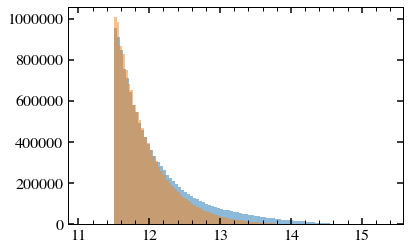

In [6]:
plt.hist(np.log10(halocat["parent_mvir"]), bins=100, alpha=0.5)
plt.hist(np.log10(halocat["mvir"]), bins=100, alpha=0.5)
plt.show()
         

### ...or just remove select model magnitude columns and not reload

In [ ]:
for c in halocat.colnames:
    if (f"{band}_sig" in c) | (c==f"{band}_scattered") | (c==band):
        halocat.remove_column(c)


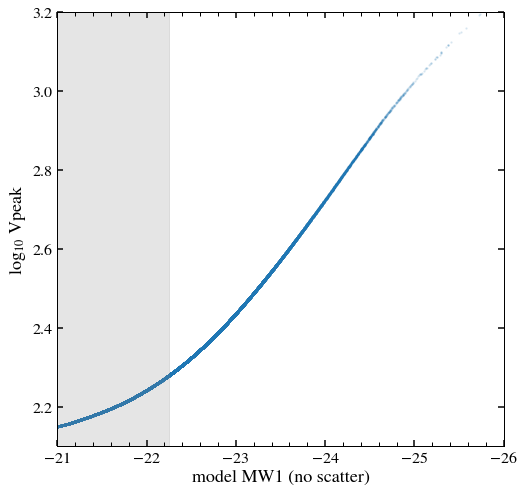

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(halocat[f"{band}_no_scatter"][::100], np.log10(halocat[sham_tag])[::100], s=2, alpha=0.1)
ax.set_xlim(-21,-26)
ax.set_ylim(2.1,3.2)
ax.set_xlabel(f"model {band} (no scatter)")
ax.set_ylabel("log$_{10}$ Vpeak")

ax.fill_between((ax.get_xlim()[0],abs_mag_lim),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.2)

plt.show()


In [8]:
abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)

# print("max galaxy number density")
# print( np.max( np.array(lum_func_full["ng_eff"]) ) )
print("galaxy number density at magnitude limit [Mpc^(-3)]:")
ng = np.max( np.array(lum_func_full["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] )
print( np.round(ng,6) )

# print(int(np.max( np.array(lum_func_full["ng_eff"]) ) * (vol_sim/(h**3)) ))
Nhalo_select = int(np.max( np.array(lum_func_full["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] ) * (vol_sim/(h**3)) )

print("\nnumber of halos to select to achieve target number density:")
print(Nhalo_select)

print(len(halocat[halocat[f"{band}_no_scatter"] <= abs_mag_lim]))


galaxy number density at magnitude limit [Mpc^(-3)]:
0.00172

number of halos to select to achieve target number density:
5524812
5901679


[-22.25 -22.55 -22.85 -23.15 -30.  ]
[-22.55]
sig0	0.7
alpha	0.5
beta	2
M0	-22.55
(sig0, alpha, beta, M0) = (0.7, 0.5, 2, -22.55)


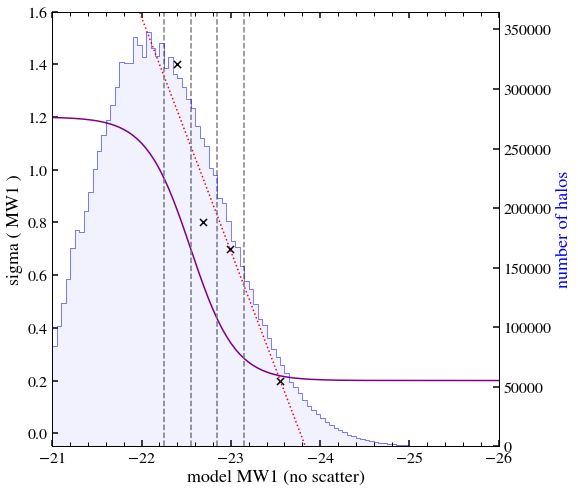

In [42]:
#-- tanh SHAM scatter

fig, ax = plt.subplots(1, 1, figsize=(8,8))

# sig0 = np.mean([np.min(y_sham),np.max(y_sham)])
# A    = 0.5*( np.max(y_sham) - np.min(y_sham) )
# M0   = np.mean(x)
sig0  = 0.7
alpha = 0.5
beta  = 2
print(abs_mag_bins_clust[::-1])
print(abs_mag_bins_clust[3:4])
M0    = np.mean(abs_mag_bins_clust[3:4]) #-22.25
sigma_tanh = sig0 - alpha*np.tanh( beta*(-abs_mag_bins + M0) )
print(f"sig0\t{sig0}")
print(f"alpha\t{alpha}")
print(f"beta\t{beta}")
print(f"M0\t{M0}")
print(f"(sig0, alpha, beta, M0) = ({sig0}, {alpha}, {beta}, {M0})")

ax.plot(abs_mag_bins, sigma_tanh, color="purple")

ax.set_xlim(-21,-26)
ax.set_ylim(-0.05,1.6)
ax.set_xlabel(f"model {band} (no scatter)")
ax.set_ylabel(f"sigma ( {band} )")

ax.scatter(x, y_sham, marker="x", color="k", s=50)

m_sham, b_sham = fit_popt["w4"][:2]
ax.plot(abs_mag_bins, m_sham*abs_mag_bins + b_sham, color="red", ls=":")

for mm in abs_mag_bins_clust:
    ax.plot(mm*np.ones(2), ax.get_ylim(), color="gray", ls="--")

ax1 = ax.twinx()
ax1.hist(halocat[f"{band}_no_scatter"], bins=abs_mag_bins, color="blue", histtype="step", lw=0.5)
ax1.hist(halocat[f"{band}_no_scatter"], bins=abs_mag_bins, color="blue", alpha=0.05)
ax1.set_ylabel("number of halos", color="blue")    
    
plt.show()


In [43]:
%%time

#################################################
##  Set functional type for mag-vpeak scatter  ##
#################################################

nsig_clip = 2.5

# popt_sham_key  = "w4"
# m_sham, b_sham = fit_popt[popt_sham_key][:2]

###################################################
##  Compute sigma (array) for mag-vpeak scatter  ##
###################################################

# #-- linear w4
# sigma_abs_mag_inferred = m_sham*halocat[f"{band}_no_scatter"].data + b_sham
# #-- replace negative sigma values with zero if needed
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < 0)[0]] = 0

# #-- fake tanh A
# sigma_abs_mag_inferred = m_sham*halocat[f"{band}_no_scatter"].data + b_sham
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < np.min(y_sham))[0]] = np.min(y_sham)
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred > np.max(y_sham))[0]] = np.max(y_sham)

# #-- fake tanh B
# p1 = (abs_mag_bins_clust[-2],y_sham[-1])
# p2 = (abs_mag_bins_clust[1], y_sham[0])
# slope     = (p2[-1]-p1[-1]) / (p2[0]-p1[0])
# intercept = p1[-1] - slope*p1[0]
# sigma_abs_mag_inferred = slope*halocat[f"{band}_no_scatter"].data + intercept
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < np.min(y_sham))[0]] = np.min(y_sham)
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred > np.max(y_sham))[0]] = np.max(y_sham)

#-- custom tanh
sigma_abs_mag_inferred = sig0 - alpha*np.tanh( beta*(-halocat[f"{band}_no_scatter"].data + M0) )

# #-- constant
# sigma_abs_mag_inferred = sigma_sham_const

print(sigma_abs_mag_inferred)


[0.20000073 0.20000058 0.20000065 ... 1.2        1.2        1.2       ]
CPU times: user 237 ms, sys: 79.9 ms, total: 317 ms
Wall time: 316 ms


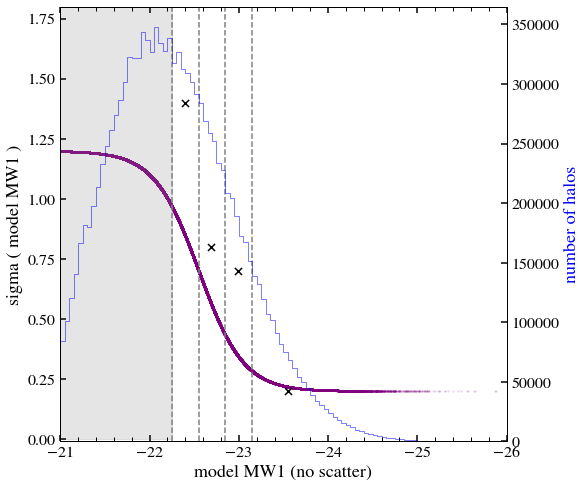

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(halocat[f"{band}_no_scatter"][::100], sigma_abs_mag_inferred[::100], s=2, alpha=0.1, color="purple")

ax.set_xlim(-21,-26)
ax.set_ylim(-0.01,1.8)
ax.set_xlabel(f"model {band} (no scatter)")
ax.set_ylabel(f"sigma ( model {band} )")

ax.scatter(x, y_sham, marker="x", color="k", s=50)

for mm in abs_mag_bins_clust:
    ax.plot(mm*np.ones(2), ax.get_ylim(), color="gray", ls="--")
    
ax.fill_between((ax.get_xlim()[0],abs_mag_lim),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.2)
    
ax1 = ax.twinx()
ax1.hist(halocat[f"{band}_no_scatter"], bins=abs_mag_bins, histtype="step", color="blue", lw=0.5)
ax1.set_ylabel("number of halos", color="blue")

plt.show()


In [45]:
###########################################
##  Add scattered magnitudes to catalog  ##
###########################################

#-- add scatter to inferred magnitudes
abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"],
                                                 sigma_abs_mag_inferred)


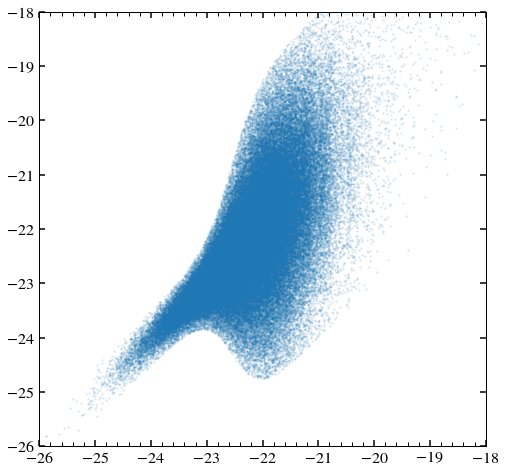

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(halocat[f"{band}_no_scatter"][::100], abs_mag_inferred_scattered[::100], s=2, alpha=0.1)
ax.set_xlim(-26,-18)
ax.set_ylim(-26,-18)

plt.show()


In [47]:
#-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
#-- temporary column for intermediate SHAM step
cname_temp = f"{band}_scattered"
if cname_temp in halocat.colnames:
    halocat.remove_column( cname_temp )
halocat.add_column( Column(abs_mag_inferred_scattered, name=cname_temp) )


In [48]:
halocat.sort( cname_temp )


In [49]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.scatter(halocat[f"{band}_no_scatter"][::100], abs_mag_inferred_scattered[::100], s=2, alpha=0.1)
# ax.set_xlim(-26,-18)
# ax.set_ylim(-26,-18)

# plt.show()

In [50]:
abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
abs_mag_inferred_sorted.sort()

cname_final = f"{band}"

if cname_final in halocat.colnames:
    halocat.remove_column( cname_final )
halocat.add_column( Column(abs_mag_inferred_sorted, name=cname_final) )

#-- add column for galaxy flag
if "galaxy" not in halocat.colnames:
    halocat.add_column( Column(np.zeros(len(halocat),dtype=bool), name="galaxy"))


In [51]:
%%time

gal_candidates = halocat[ halocat[band] <= abs_mag_lim ]
extra_halos    = halocat[ halocat[band] > abs_mag_lim ]

#-- sort catalog by model magnitude
gal_candidates.sort( band )
assert(gal_candidates[band][0] < gal_candidates[band][-1])

#-- flag halos with galaxies
gal_candidates["galaxy"][:Nhalo_select] = True

galcat = gal_candidates[gal_candidates["galaxy"]==True]

extra_halos = vstack( [gal_candidates[gal_candidates["galaxy"]==False], extra_halos] )


CPU times: user 4.22 s, sys: 1.39 s, total: 5.61 s
Wall time: 5.75 s


In [36]:
print(len(halocat))

print(len(halocat[halocat[band] <= abs_mag_lim]))

print(len(galcat))

print(len(extra_halos))

print(len(galcat) + len(extra_halos))


13056580
5901679
5524812
7531768
13056580


In [ ]:
# %%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}"

# np.save( f"{f}_galcat.npy", galcat )

# np.save( f"{f}_extra-halos.npy", extra_halos )


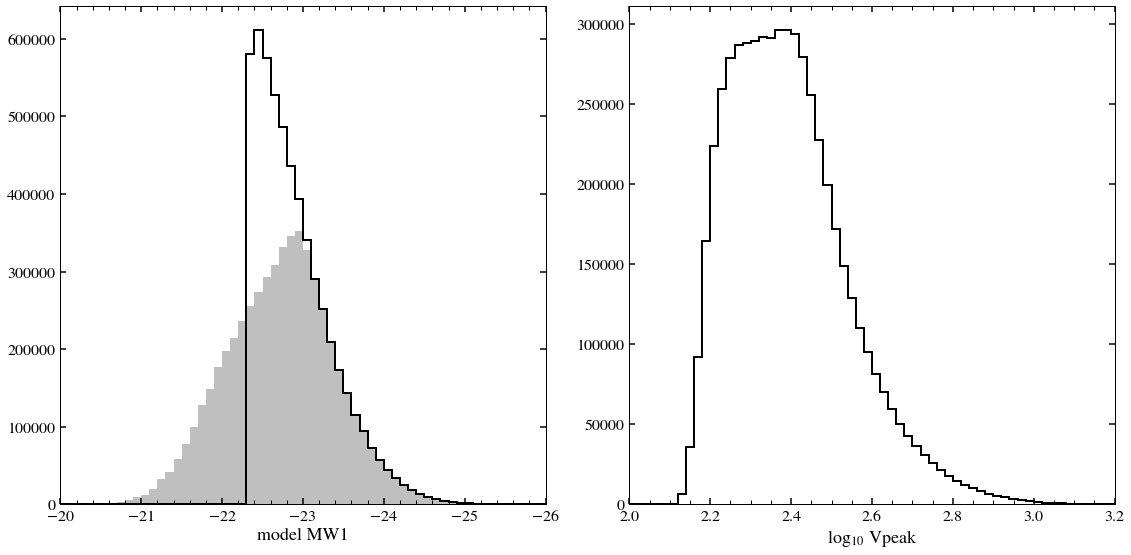

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
ax.hist(galcat[f"{band}_no_scatter"], bins=abs_mag_bins[::2], color="gray", alpha=0.5)
ax.hist(galcat[band], bins=abs_mag_bins[::2], histtype="step", lw=2, color="k")
ax.set_xlim(-20,-26)
ax.set_xlabel(f"model {band}")

ax = axes[1]
ax.hist(np.log10(galcat["vpeak"]), bins=np.arange(2,3.4,0.02), histtype="step", lw=2, color="k")
ax.set_xlim(2, 3.2)
ax.set_xlabel(r"log$_{10}$ Vpeak")

plt.tight_layout()

plt.show()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(galcat[band][::100], np.log10(galcat["vpeak"])[::100], s=2, alpha=0.1)
ax.scatter(galcat[f"{band}_no_scatter"][::100], np.log10(galcat["vpeak"])[::100], s=2, alpha=0.1)

plt.show()


# Clustering

### magnitude bins

1000
843
1775
1792


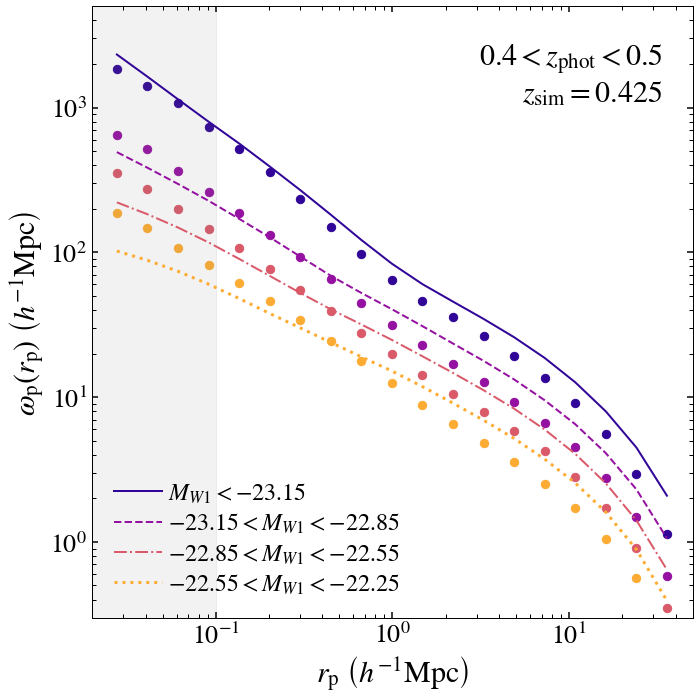

CPU times: user 1min 29s, sys: 2.49 s, total: 1min 31s
Wall time: 1min 28s


In [38]:
%%time

from scipy.signal import savgol_filter

model_mags = galcat[band].data

save = False
# popt_los_key = "_4"
# m_los, b_los = fit_popt[popt_los_key][2:]

# sigma_los = m_los*model_mags.data + b_los
# sigma_los[sigma_los < 0] = 0

sigma_los = 0.0 * np.ones(len(galcat))

n_iter   = 1
nthreads = 2
DS       = 1
cross    = "GXG"

colors     = get_colors(4)
linestyles = ("-","--","dashdot",":")
linewidths = (2, 2, 2, 3)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

for i,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
    #-- DATA
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

    data   = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"].data
    wp_dat = h*data["wp"].data
    wp_err = h*np.sqrt(data["wp_err"].data)

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
    cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_cen, pimax=pimax)
    cov_inv = np.linalg.inv(cov)


    #-- MODEL
    mag_min, mag_max = abs_mag_bins_clust[i:i+2]
    mag_mask = (model_mags > mag_min) & (model_mags <= mag_max)

    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx = galcat[u]
        yy = galcat[v]
        zz = galcat[w]
        z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        args = (boxsize, pimax, nthreads, bin_file_comoving, xx[mag_mask][::DS], yy[mag_mask][::DS])
        out.append([wp_corrfunc(*args, z_s[mag_mask][::DS], output_rpavg=False)["wp"] for z_s in z_scatter])

    out = np.concatenate(out).T

    wp_mod = np.mean(out, axis=1)

    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))

    chisq = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])

    label = get_abs_mag_bin_label(abs_mag_bin_tag)# + f" ($\chi^2 \sim {10*int(chisq/10)}$)"
    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
    two_halo = (rp_cen > 1.0)
    pct_diff = 1 - wp_mod/wp_dat
    print( f"{int(chisq)}") #"\t{np.mean(pct_diff[one_halo]):.3f}\t{np.mean(pct_diff[two_halo]):.3f}" )
    ax.scatter(rp_cen, 10**(np.log10(wp_dat)-0.15*i), color=colors[i], s=70)
    #ax.errorbar(rp_cen, wp_dat, yerr=wp_err, color=colors[i], ls="")
    ax.plot(rp_cen, savgol_filter(10**(np.log10(wp_mod)-0.15*i),7,3), label=label, color=colors[i], ls=linestyles[i], lw=linewidths[i])

ax.loglog()
ax.set_xlim(0.02,50)
ax.set_ylim(0.3,5e3)

ax.tick_params(axis="both", which="major", labelsize=26)
ax.set_xlabel(fig_labels["rp"], fontsize=30)
ax.set_ylabel(fig_labels["wp"], fontsize=30)

ax.legend(loc=3, fontsize=24, labelspacing=0.25, handletextpad=0.25)

zphot_label = f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$"
zsim_label  = r"$z_{\rm sim} = $" + f"${np.round(zsim,3)}$"
# txt = f"SHAM {popt_sham_key}" + "\n" + f"LOS {popt_los_key}" + "\n" + zsim_label
ax.text(*get_corners(ax,log=True)["upper_right"], zphot_label + "\n" + zsim_label, ha="right", va="top", fontsize=30)

ax.fill_between((ax.get_xlim()[0],0.1),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

plt.tight_layout()

if save:
    figname = f"{BASEDIR}/figures/wp-compare_mag-bins_{cat_tag[:-6]}_{band}.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
np.round(m_los,1), np.round(b_los,1)


[RETURN TO LOAD MOCK](#load_mock)

### full mock clustering

0.038
-0.327


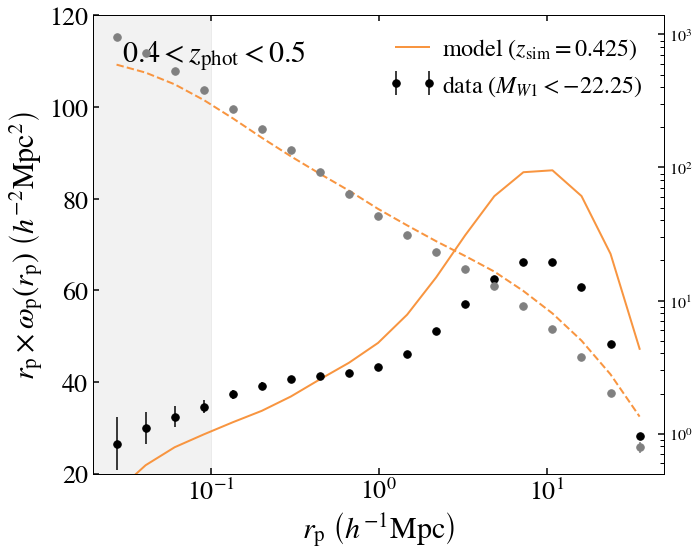

CPU times: user 3.96 s, sys: 188 ms, total: 4.15 s
Wall time: 3.04 s


In [41]:
%%time

model_mags = galcat[band].data

save = False
# popt_los_key = "_4"
# m_los, b_los = fit_popt[popt_los_key][2:]

# sigma_los = m_los*model_mags.data + b_los
# sigma_los[sigma_los < 0] = 0

sigma_los =70. * np.ones(len(galcat))

n_iter   = 1
nthreads = 2
DS       = 20
cross    = "GXG"

c_opt, c_IR = get_colors(2)
color = c_IR if band=="MW1" else c_opt

zphot_label = f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$"
zsim_label  = r"$z_{\rm sim} = $" + f"${np.round(zsim,3)}$"

fig, ax = plt.subplots(1, 1, figsize=(10,8))

#-- DATA
fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

data   = ascii.read(f"{fpath}/{wp_fname}")
rp_cen = h*data["rp_cen"].data
wp_dat = h*data["wp"].data
wp_err = h*np.sqrt(data["wp_err"].data)

#-- MODEL
out = []
for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
    xx = galcat[u]
    yy = galcat[v]
    zz = galcat[w]
    z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
    z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
    z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

    args = (boxsize, pimax, nthreads, bin_file_comoving, xx[::DS], yy[::DS])
    out.append([wp_corrfunc(*args, z_s[::DS], output_rpavg=False)["wp"] for z_s in z_scatter])
out = np.concatenate(out).T
wp_mod = np.mean(out, axis=1)

rp_use_min, rp_use_max = rp_use_range
if (rp_use_min != None) & (rp_use_max != None):
    rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
elif (rp_use_min != None) & (rp_use_max==None):
    rp_use_idx = np.where(rp_cen > rp_use_min)[0]
elif (rp_use_min==None) & (rp_use_max != None):
    rp_use_idx = np.where(rp_cen < rp_use_max)[0]
else:
    rp_use_idx = np.arange(len(rp_cen))

one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
two_halo = (rp_cen > 1.0)
pct_diff = 1 - wp_mod/wp_dat
print( f"{np.mean(pct_diff[one_halo]):.3f}\n{np.mean(pct_diff[two_halo]):.3f}" )

if band=="MW1":
    abs_mag_lim_label = r"$(M_{W1}$" + f"$ < {abs_mag_lim})$"
elif band=="Mz":
    abs_mag_lim_label = f"$(M_z < {abs_mag_lim})$"
else:
    raise Exception()

label_data = "data " + abs_mag_lim_label# + "\n" + zphot_label
ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=wp_err, color="k", ls="", marker=".", ms=15, label=label_data)
ax.plot(rp_cen, savgol_filter(rp_cen*wp_mod,7,3), label="model (" + zsim_label + ")", color=color, lw=2)

ax.semilogx()
ax.set_xlim(0.02,50)
ax.set_ylim(20,120)

ax.tick_params(axis="both", which="major", labelsize=26)
ax.set_xlabel(fig_labels["rp"], fontsize=30)
ax.set_ylabel(fig_labels["rpwp"], fontsize=30)

ax.legend(loc=1, fontsize=24, numpoints=2, handletextpad=0.25)#, labelspacing=0.25)

ax.text(*get_corners(ax,logx=True)["upper_left"], zphot_label, ha="left", va="top", fontsize=30)

ax.fill_between((ax.get_xlim()[0],0.1),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

ax1 = ax.twinx()
ax1.errorbar(rp_cen, wp_dat, yerr=wp_err, color="gray", ls="", marker=".", ms=15)
ax1.semilogy(rp_cen, savgol_filter(wp_mod,7,3), color=color, lw=2, ls="--")

plt.tight_layout()

if save:
    figname = f"{BASEDIR}/figures/wp-compare_{cat_tag[:-6]}_{band}.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
# t = Table(np.load(f"{BASEDIR}/summary_{this_band}_zsnap0p52323.npy"))

# mask = (np.abs(t["pct_diff_1h"])==np.min(np.abs(t["pct_diff_1h"]))) & (np.abs(t["pct_diff_2h"])==np.min(np.abs(t["pct_diff_2h"])))

# fig, ax = plt.subplots(1, 1, figsize=(6,4))

# ss = t["sigma_sham"]
# ax.scatter(ss, np.abs(t["pct_diff_1h"]))
# ax.scatter(ss, np.abs(t["pct_diff_2h"]))

# plt.tight_layout()
# plt.show()

# Table(t[mask])
